# Introduction
In this notebook we are analyzing the Clementine cuisine prediction dataset. The dataset consistists of list of ingredients for different recipies coming from 20 different cuisines. Our task is to predict the cuisine just looking at/analyzing the list of ingredients of a recipe.

In [257]:
# Importing necessary packages
import json
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Softmax
from keras.metrics import mean_squared_error
import copy
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [253]:
#Loadig the training and testing datasets
f = open('data/test.json')
data_test = json.load(f)
f.close()
f = open('data/train.json')
data_train = json.load(f)
f.close()

## Preprocessing and Data Cleaning
We are preprocessing and cleaning the given dataset in two steps.
- In the first step we are making sure that all the ingredients are written in lower case.
- In the next step we are looking for pair of datapoints with same set of ingredients but listed under two different cuisines. We remove such datapoints from the training data.

In [254]:
# In this step we are making sure that all the ingredients are written in lowercase.
clean_data_train = []
for recipe in data_train:
    temp = recipe
    ingredients_lower = []
    for j in recipe['ingredients']:
        ingredients_lower.append(j.lower())
    temp['ingredients'] = ingredients_lower
    clean_data_train.append(temp)
data_train = copy.deepcopy(clean_data_train)

In [255]:
# In this step we are loking for pair of datapoints with same set of ingredients but corresponding to different cuisines.
# We are also removing such datapoints from the dataset.
Confusing_data = []
for i in range(len(data_train)):
    for j in range(i,len(data_train)):
        if set(data_train[i]['ingredients'])==set(data_train[j]['ingredients']) and data_train[i]['cuisine'] != data_train[j]['cuisine']:
            Confusing_data.append((i,j))
redundant = [i[0] for i in Confusing_data] + [i[1] for i in Confusing_data]
clean_data_train = []
for i in range(len(data_train)):
    if i not in redundant:
        clean_data_train.append(data_train[i])
data_train = copy.deepcopy(clean_data_train)

In [259]:
# Creating the target dataset y
y = [i['cuisine'] for i in data_train]
y = pd.DataFrame(y,columns=['Cuisine'])

# Printing how many datapoints we have corresponding to each cuisine
count = 1
for j in set(y.Cuisine):
    print('%i Cuisine: %s'%(count,j))
    count+= 1
    print('Occurrence: %i'%list(y.Cuisine).count(j))
    print('\n')

1 Cuisine: russian
Occurrence: 489


2 Cuisine: british
Occurrence: 804


3 Cuisine: vietnamese
Occurrence: 823


4 Cuisine: cajun_creole
Occurrence: 1545


5 Cuisine: greek
Occurrence: 1173


6 Cuisine: moroccan
Occurrence: 820


7 Cuisine: indian
Occurrence: 3002


8 Cuisine: irish
Occurrence: 665


9 Cuisine: korean
Occurrence: 830


10 Cuisine: southern_us
Occurrence: 4316


11 Cuisine: mexican
Occurrence: 6436


12 Cuisine: french
Occurrence: 2641


13 Cuisine: spanish
Occurrence: 987


14 Cuisine: chinese
Occurrence: 2671


15 Cuisine: thai
Occurrence: 1539


16 Cuisine: brazilian
Occurrence: 467


17 Cuisine: japanese
Occurrence: 1421


18 Cuisine: filipino
Occurrence: 754


19 Cuisine: jamaican
Occurrence: 526


20 Cuisine: italian
Occurrence: 7835




## Model selection
In this analysis we tried a few different models and explaining the best perfroming ones among them. All our models are two step hybrid model where in the first step we look for presence of some special ingredients in the set of ingredients. Then in case we fail in the first step we go on to the second step where we predict the cuisine of the recipe using a ML algorithm or a Support Vector Machine (SVM) we have train on the training dataset.

- First we extract special set of ingredients which are exclusive to each cuisine. Namely, we create a dictionary with cuisines as keys and the value corresponding to each cuisine is a set of ingredients that appears in some recipie(s) in that cuisine but does not appear in the set of ingredients to any other cuisine.

- The second step our models can be further divided in two parts. 
    - First we compute an embedding of our data in a smaller dimensional space. We tried two different methods for finding out the embeddings. One is using **Word2Vec** from *gensim* and the other one is finding the PCA from one hot vectors.
    - Once we have the data embedded in smaller dimensional space we tried two metods to to come up with predictions from there. We trained a shallow Neural Network on both the data embeddings, which has 20 Dense units as input layer followed by a Softmax unit as output layer. The other method we tried is training a Support Vector Machine on the embedded data with linear kernel. We observed that SVM's with polynomial kernel takes longer to train and produce prediction on our data and also performs with slightly less accuracy. So in this notebook we are presenting and comparing the performance of SVMs with linear kernel.

In [260]:
# Here we prepare the set of Special ingredients exclusive to one cuisine.
Sets = dict()
Special = dict()

for cuisine in set(y.Cuisine):
    Sets[cuisine] = set()

for recipe in data_train:
    Sets[recipe['cuisine']] = Sets[recipe['cuisine']].union(set(recipe['ingredients']))

for cuisine in set(y.Cuisine):
    Special[cuisine] = Sets[cuisine]
    for j in set(y.Cuisine) - {cuisine}:
        Special[cuisine] = Special[cuisine] - Sets[j] 
Special_ingredients = set()
for ingredients in Special.values():
    Special_ingredients = Special_ingredients.union(ingredients)
    
# Here we create the list of ingredients which are not exclusive to one cuisine.
Ingredients = set()
for recipe in data_train:
    Ingredients = Ingredients.union(set(recipe['ingredients']))
Ingredients = list(Ingredients - Special_ingredients)

In [261]:
# Building the list of sentences of ingredients on which we will calculate the "Word2Vec". 
sentences = []
for recipe in data_train:
    ingredients = set(recipe['ingredients']) - Special_ingredients
    sentences.append(list(ingredients))

In [262]:
# Creating the word embedding model here. 
# Please note 'embedding_dimension' is a hyperparameter here.
embedding_dimension = 140
w2v = Word2Vec(sentences, min_count=3, vector_size = embedding_dimension)
word_vectors = w2v.wv

In [263]:
# Supplimentary function to calculate embedding of a list of ingredients.
def recipe_embedding(ingredients, embedding_dimension = embedding_dimension):
    v = np.zeros(embedding_dimension)
    for j in ingredients:
        try:
            v+= word_vectors[j]
        except:
            v+= 0
    return v

In [265]:
# Creating the training dataframe 'X'
Data = np.zeros((len(data_train),embedding_dimension))
y_check = []
for i in range(len(data_train)):
    Data[i,:] = recipe_embedding(data_train[i]['ingredients'])
    y_check.append(data_train[i]['cuisine'])
X_w2v = pd.DataFrame(Data)
y_dummies = pd.get_dummies(pd.DataFrame(y_check))

In [266]:
# Creating a shallow NN to train on the embedding given by "Word2Vec".
Model = Sequential(
    [
        Dense(20, input_dim=embedding_dimension, activation = 'relu', name='Input_Dense',),
        #Dense(20, activation= 'relu'),
        Softmax(1, name = 'Output_Softmax'),
    ]
)
Model.compile(loss=mean_squared_error, optimizer= 'Adam', metrics= 'accuracy')
Model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Dense (Dense)          (None, 20)                2820      
_________________________________________________________________
Output_Softmax (Softmax)     (None, 20)                0         
Total params: 2,820
Trainable params: 2,820
Non-trainable params: 0
_________________________________________________________________


In [267]:
# Normalizing the training data before training the NN model on it.
M = X_w2v.mean()
S = X_w2v.std()
X_w2v_norm = (X_w2v - M)/S

In [318]:
y_check.count('greek')/len(y_check)

0.029513888888888888

In [268]:
# Creating the training and validation split.
# Since our data is skewed we are stratifying it.
X_w2v_train, X_w2v_val, y_train, y_val = train_test_split(X_w2v_norm,y_dummies,
                                                  test_size = .2,
                                                 shuffle=True,
                                                 stratify=y_check)

In [269]:
history = Model.fit(X_w2v_train,
                    y_train,
                    validation_data=(X_w2v_val,y_val),
                    epochs=100, 
                    batch_size = 4)

Epoch 1/100
7949/7949 [==============================] - 23s 3ms/step - loss: 0.0270 - accuracy: 0.5918 - val_loss: 0.0264 - val_accuracy: 0.6057
Epoch 2/100
7949/7949 [==============================] - 20s 3ms/step - loss: 0.0254 - accuracy: 0.6216 - val_loss: 0.0254 - val_accuracy: 0.6232
Epoch 3/100
7949/7949 [==============================] - 20s 3ms/step - loss: 0.0250 - accuracy: 0.6299 - val_loss: 0.0254 - val_accuracy: 0.6210
Epoch 4/100
7949/7949 [==============================] - 20s 3ms/step - loss: 0.0247 - accuracy: 0.6337 - val_loss: 0.0249 - val_accuracy: 0.6294
Epoch 5/100
7949/7949 [==============================] - 21s 3ms/step - loss: 0.0245 - accuracy: 0.6370 - val_loss: 0.0247 - val_accuracy: 0.6353
Epoch 6/100
7949/7949 [==============================] - 21s 3ms/step - loss: 0.0244 - accuracy: 0.6411 - val_loss: 0.0249 - val_accuracy: 0.6325
Epoch 7/100
7949/7949 [==============================] - 21s 3ms/step - loss: 0.0242 - accuracy: 0.6440 - val_loss: 0.0245 -

Epoch 57/100
7949/7949 [==============================] - 18s 2ms/step - loss: 0.0229 - accuracy: 0.6664 - val_loss: 0.0235 - val_accuracy: 0.6523
Epoch 58/100
7949/7949 [==============================] - 18s 2ms/step - loss: 0.0229 - accuracy: 0.6674 - val_loss: 0.0238 - val_accuracy: 0.6499
Epoch 59/100
7949/7949 [==============================] - 19s 2ms/step - loss: 0.0229 - accuracy: 0.6668 - val_loss: 0.0238 - val_accuracy: 0.6481
Epoch 60/100
7949/7949 [==============================] - 18s 2ms/step - loss: 0.0229 - accuracy: 0.6681 - val_loss: 0.0239 - val_accuracy: 0.6515
Epoch 61/100
7949/7949 [==============================] - 18s 2ms/step - loss: 0.0229 - accuracy: 0.6669 - val_loss: 0.0238 - val_accuracy: 0.6486
Epoch 62/100
7949/7949 [==============================] - 18s 2ms/step - loss: 0.0229 - accuracy: 0.6662 - val_loss: 0.0236 - val_accuracy: 0.6547
Epoch 63/100
7949/7949 [==============================] - 18s 2ms/step - loss: 0.0229 - accuracy: 0.6672 - val_loss: 0

Text(0, 0.5, 'Mean Squared Error')

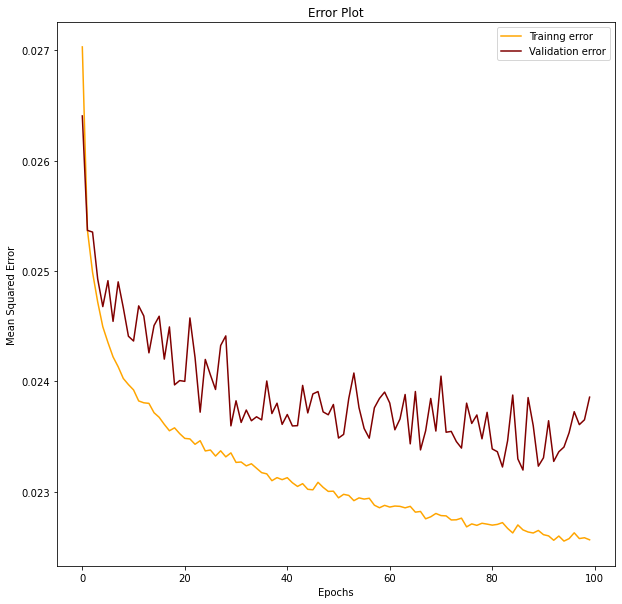

In [276]:
plt.figure(figsize = (10,10))
plt.plot(history.history['loss'], label = 'Trainng error', color = 'orange')
plt.plot(history.history['val_loss'], label = 'Validation error', color = 'maroon')
plt.title('Error Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')

Text(0, 0.5, 'Accuracy')

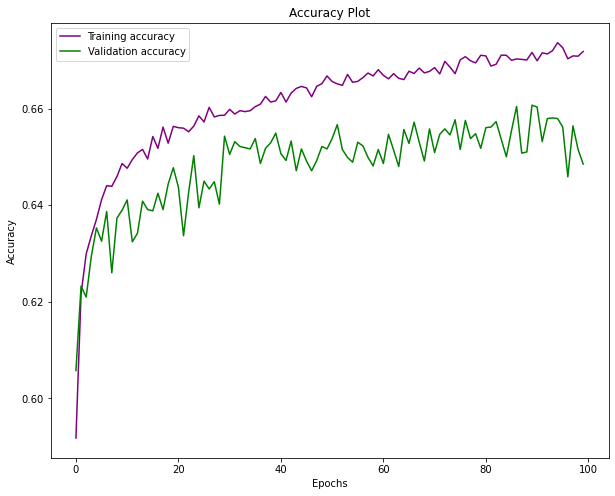

In [277]:
plt.figure(figsize = (10,8))
plt.plot(history.history['accuracy'], label = 'Training accuracy', color = 'purple')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy', color = 'green')
plt.title('Accuracy Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [279]:
# Saving our model to save training time in future.
Model.save('Model_special.H5')

INFO:tensorflow:Assets written to: Model_special.H5\assets


INFO:tensorflow:Assets written to: Model_special.H5\assets


## Moment of Truth
Here we are going to test the overall accuracy of our 2-step hybrid model. For that we will pick 1000 random datapoints from the traing dataset and then will measure what percentage of them our model predicted correctly.

In [278]:
# Testing accuracy of the hybrid model
Incorrect = 0
Correct = 0
num_samples = 1000
for i in range(num_samples):
    n = np.random.randint(0,len(data_train))
    if any(ele in Special_ingredients for ele in data_train[n]['ingredients']):
        for cuisine in Special.keys():
            if any(ele in Special[cuisine] for ele in data_train[n]['ingredients']):
                if cuisine == data_train[n]['cuisine']:
                    Correct+= 1
                else:
                    Incorrect+= 1
                break
    else:
        test_vec = np.array((recipe_embedding(data_train[n]['ingredients'])-M)/S).reshape(1,embedding_dimension)
        pred = Model.predict(test_vec)
        if y_dummies.columns[np.argmax(pred)].replace('0_','') == data_train[n]['cuisine']:
            Correct+= 1
        else:
            Incorrect+=1
print('\nAcuracy: %.2f' %(Correct/(num_samples)*100),'%')


Acuracy 70.20 %


### Computing PCA Embedding
Now we are first going compute the one-hot encoding of our data as a $ m\times n $  matrix where $$ m = \text{number of data points} $$ and $$ n = \text{number of ingredients, not occuring in the set of special ingredients.} $$ 
Also the $ 1 \times n$ vector corresponding to each datapoint is not exactly a 1-hot vector but is sum of 1-hot vectors corresponding to the ingredinents that appears in the recipe/datapoint.

In [287]:
def one_hot_ingredients(ingredients):
    v = np.zeros((1,len(Ingredients)))
    for i in range(len(Ingredients)):
        if Ingredients[i] in ingredients:
            v[0,i] = 1
    return v
X_1_hot = np.zeros((len(data_train), len(Ingredients)))
for i in range(len(data_train)):
    X_1_hot[i,:] = one_hot_ingredients(data_train[i]['ingredients'])

In [293]:
X_1_hot.shape

(39744, 4113)

In [294]:
# We are computing the PCA of the 1-hot encoded data we prepared in the last block.
# Please note that "pca_embedding_dimension" is a hyperparameter here.
pca_embedding_dimension = 170
pca = PCA(n_components = pca_embedding_dimension)
pca.fit(X_1_hot)

PCA(n_components=170)

In [295]:
pca_components = pca.components_
X_pca = np.dot(X_1_hot,pca_components.transpose())

In [296]:
# Building the same NN model as before to train on the PCA encoded data.
Model_pca = Sequential(
    [
        Dense(20, input_dim= pca_embedding_dimension, activation = 'relu', name='Input_Dense',),
        #Dense(20, activation= 'relu'),
        Softmax(1, name = 'Output_Softmax'),
    ]
)
Model_pca.compile(loss=mean_squared_error, optimizer= 'Adam', metrics= 'accuracy')
Model_pca.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Dense (Dense)          (None, 20)                3420      
_________________________________________________________________
Output_Softmax (Softmax)     (None, 20)                0         
Total params: 3,420
Trainable params: 3,420
Non-trainable params: 0
_________________________________________________________________


In [297]:
X_pca = pd.DataFrame(X_pca)
M_pca = X_pca.mean()
S_pca = X_pca.std()
X_pca_norm = (X_pca - M_pca)/S_pca

In [300]:
X_pca_train, X_pca_val, y_train, y_val = train_test_split(X_pca_norm,y_dummies,
                                                  test_size = .2,
                                                 shuffle=True,
                                                 stratify=y_check)

In [301]:
history = Model_pca.fit(X_pca_train,
                    y_train,
                    validation_data=(X_pca_val, y_val),
                    epochs=100, 
                    batch_size = 4)

Epoch 1/100
7949/7949 [==============================] - 10s 1ms/step - loss: 0.0289 - accuracy: 0.5584 - val_loss: 0.0236 - val_accuracy: 0.6588
Epoch 2/100
7949/7949 [==============================] - 10s 1ms/step - loss: 0.0228 - accuracy: 0.6700 - val_loss: 0.0230 - val_accuracy: 0.6683
Epoch 3/100
7949/7949 [==============================] - 10s 1ms/step - loss: 0.0222 - accuracy: 0.6811 - val_loss: 0.0227 - val_accuracy: 0.6707
Epoch 4/100
7949/7949 [==============================] - 10s 1ms/step - loss: 0.0219 - accuracy: 0.6873 - val_loss: 0.0230 - val_accuracy: 0.6712
Epoch 5/100
7949/7949 [==============================] - 11s 1ms/step - loss: 0.0217 - accuracy: 0.6900 - val_loss: 0.0229 - val_accuracy: 0.6732
Epoch 6/100
7949/7949 [==============================] - 10s 1ms/step - loss: 0.0215 - accuracy: 0.6937 - val_loss: 0.0229 - val_accuracy: 0.6708
Epoch 7/100
7949/7949 [==============================] - 11s 1ms/step - loss: 0.0214 - accuracy: 0.6956 - val_loss: 0.0229 -

Epoch 57/100
7949/7949 [==============================] - 10s 1ms/step - loss: 0.0202 - accuracy: 0.7189 - val_loss: 0.0235 - val_accuracy: 0.6772
Epoch 58/100
7949/7949 [==============================] - 10s 1ms/step - loss: 0.0202 - accuracy: 0.7191 - val_loss: 0.0235 - val_accuracy: 0.6739
Epoch 59/100
7949/7949 [==============================] - 11s 1ms/step - loss: 0.0202 - accuracy: 0.7206 - val_loss: 0.0236 - val_accuracy: 0.6753
Epoch 60/100
7949/7949 [==============================] - 11s 1ms/step - loss: 0.0202 - accuracy: 0.7203 - val_loss: 0.0237 - val_accuracy: 0.6689
Epoch 61/100
7949/7949 [==============================] - 13s 2ms/step - loss: 0.0202 - accuracy: 0.7187 - val_loss: 0.0236 - val_accuracy: 0.6728
Epoch 62/100
7949/7949 [==============================] - 11s 1ms/step - loss: 0.0202 - accuracy: 0.7210 - val_loss: 0.0237 - val_accuracy: 0.6734
Epoch 63/100
7949/7949 [==============================] - 12s 2ms/step - loss: 0.0202 - accuracy: 0.7211 - val_loss: 0

In [302]:
Model_pca.save('Model_pca.H5')

INFO:tensorflow:Assets written to: Model_pca.H5\assets


INFO:tensorflow:Assets written to: Model_pca.H5\assets


Text(0, 0.5, 'Mean Squared Error')

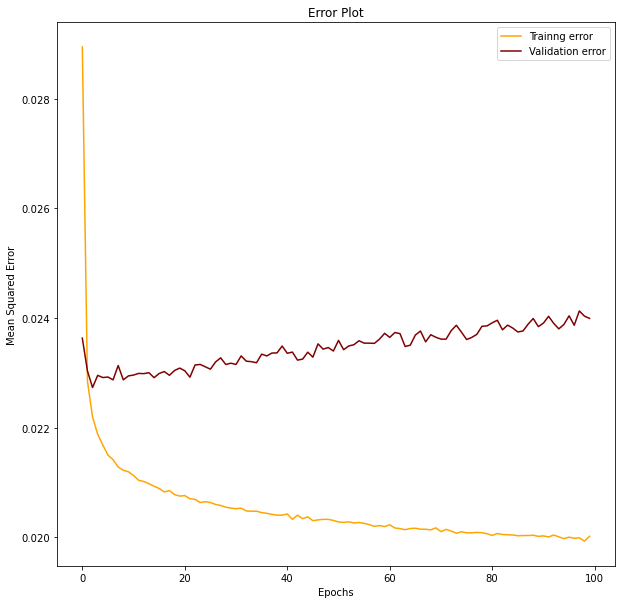

In [303]:
plt.figure(figsize = (10,10))
plt.plot(history.history['loss'], label = 'Trainng error', color = 'orange')
plt.plot(history.history['val_loss'], label = 'Validation error', color = 'maroon')
plt.title('Error Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')

Text(0, 0.5, 'Accuracy')

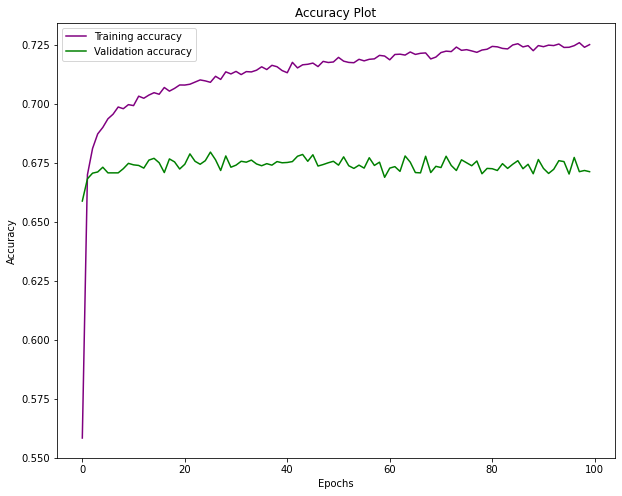

In [304]:
plt.figure(figsize = (10,8))
plt.plot(history.history['accuracy'], label = 'Training accuracy', color = 'purple')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy', color = 'green')
plt.title('Accuracy Plot')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [305]:
# Testing accuracy of the hybrid model

Incorrect = 0
Correct = 0
num_samples = 1000
for i in range(num_samples):
    n = np.random.randint(0,len(data_train))
    if any(ele in Special_ingredients for ele in data_train[n]['ingredients']):
        for cuisine in Special.keys():
            if any(ele in Special[cuisine] for ele in data_train[n]['ingredients']):
                if cuisine == data_train[n]['cuisine']:
                    Correct+= 1
                else:
                    Incorrect+= 1
                break
    else:
        test_vec = one_hot_ingredients(data_train[n]['ingredients'])
        test_vec = np.dot(test_vec,pca_components.transpose())
        test_vec = (test_vec - M_pca.to_numpy())/S_pca.to_numpy()
        pred = Model_pca.predict(test_vec)
        if y_dummies.columns[np.argmax(pred)].replace('0_','') == data_train[n]['cuisine']:
            Correct+= 1
        else:
            Incorrect+=1
print('\nAcuracy: %.2f' %(Correct/(num_samples)*100),'%')


Acuracy: 73.70 %


In [310]:
y_svm = pd.DataFrame(y_check, columns=['Cuisine'])
y_svm['token'] = pd.factorize(y_svm.Cuisine)[0]

In [196]:
svm_pca = SVC(kernel = 'linear', C = 1)

In [238]:
X_pca_svm_train, X_pca_svm_val, y_pca_svm_train, y_pca_svm_val = train_test_split(X_pca, y_svm.token.values,
                                                  test_size = .2,
                                                 shuffle=True,
                                                 stratify=y_check_pca)

In [239]:
svm_pca.fit(X_pca_svm_train, y_pca_svm_train)

SVC(C=1, kernel='poly')

In [240]:
svm_pca_pred = svm_pca.predict(X_pca_svm_val)
acc = svm_pca.score(X_pca_svm_val, y_pca_svm_val)
acc

0.5760068551842331

In [216]:
# Setting up the dictionary to read off the cuisine from the predicted token
token_to_cuisine = {}
for tok in range(20):
    token_to_cuisine[tok] = list(y_svm[y_svm.token==tok].Cuisine)[0]

In [232]:
# Testing accuracy of the hybrid model

Incorrect = 0
Correct = 0
num_samples = 1000
for i in range(num_samples):
    n = np.random.randint(0,len(data_train))
    if any(ele in Special_ingredients for ele in data_train[n]['ingredients']):
        for cuisine in Special.keys():
            if any(ele in Special[cuisine] for ele in data_train[n]['ingredients']):
                if cuisine == data_train[n]['cuisine']:
                    Correct+= 1
                else:
                    Incorrect+= 1
                break
    else:
        start = time.time()
        test_vec = one_hot_ingredients(data_train[n]['ingredients'])
        test_vec = np.dot(test_vec,pca_components.transpose()).reshape(1,pca_embedding_dimension)
        pred = svm_pca.predict(test_vec)
        if token_to_cuisine[pred[0]] == data_train[n]['cuisine']:
            Correct+= 1
        else:
            Incorrect+=1
print('\nAcuracy %.2f' %(Correct/(Correct+Incorrect)*100),'%')


Acuracy 76.40 %


In [233]:
svm_model_w2v_linear = SVC(kernel = 'linear', C = 1)

In [234]:
X_train, X_val, y_train, y_val = train_test_split(X,y_svm.token.values,
                                                  test_size = .17,
                                                 shuffle=True,
                                                 stratify=y_check)
# Normalizing the training data before feeding it into the model
M = X.mean()
S = X.std()
X_train_norm = (X_train - M)/S
X_val_norm = (X_val - M)/S

In [236]:
svm_model_w2v_linear.fit(X_train_norm,y_train)

SVC(C=1, kernel='linear')

In [237]:
w2v_linear_pred = svm_model_w2v_linear.predict(X_val_norm)
acc = svm_model_w2v_linear.score(X_val_norm, y_val)
acc

0.676949443016281

In [336]:
import gensim.downloader as api
W2V = api.load("glove-wiki-gigaword-50")

In [343]:
W2V['yogurt', 'kick'].shape

(2, 50)

In [324]:
pd.DataFrame(data_train)

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39739,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39740,11462,italian,"[kraft zesty italian dressing, purple onion, b..."
39741,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39742,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [325]:
json.save('data_train_clean', data_train)

AttributeError: module 'json' has no attribute 'save'

In [326]:
import gensim.models

In [327]:
w2v_model = "./WebVectors/3/enwiki_5_ner.txt"


In [329]:
word_vectors_trial = gensim.models.KeyedVectors.load_word2vec_format(w2v_model, binary=False)

FileNotFoundError: [Errno 2] No such file or directory: './WebVectors/3/enwiki_5_ner.txt'

In [347]:
f = open('train_clean.json', 'w') as
json.dump(data_train, f)
    

[{'id': 10259,
  'cuisine': 'greek',
  'ingredients': ['romaine lettuce',
   'black olives',
   'grape tomatoes',
   'garlic',
   'pepper',
   'purple onion',
   'seasoning',
   'garbanzo beans',
   'feta cheese crumbles']},
 {'id': 25693,
  'cuisine': 'southern_us',
  'ingredients': ['plain flour',
   'ground pepper',
   'salt',
   'tomatoes',
   'ground black pepper',
   'thyme',
   'eggs',
   'green tomatoes',
   'yellow corn meal',
   'milk',
   'vegetable oil']},
 {'id': 20130,
  'cuisine': 'filipino',
  'ingredients': ['eggs',
   'pepper',
   'salt',
   'mayonaise',
   'cooking oil',
   'green chilies',
   'grilled chicken breasts',
   'garlic powder',
   'yellow onion',
   'soy sauce',
   'butter',
   'chicken livers']},
 {'id': 22213,
  'cuisine': 'indian',
  'ingredients': ['water', 'vegetable oil', 'wheat', 'salt']},
 {'id': 13162,
  'cuisine': 'indian',
  'ingredients': ['black pepper',
   'shallots',
   'cornflour',
   'cayenne pepper',
   'onions',
   'garlic paste',
   'm